# Задача 1:

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error as MAE
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Базовая модель

In [2]:
regr = pd.read_csv(r'C:\\Users\\Svyatoslav\\Downloads\\data_regression_for_task.csv')

In [3]:
# Берем последний месяц для валидации
y_valid = regr[(regr['YEAR'] == 2018) & (regr['MONTH'] == 2)]['SALES']
x_valid = regr[(regr['YEAR'] == 2018) & (regr['MONTH'] == 2)].drop(['SALES'],axis = 1)
# И убираем его из train
regr = regr[((regr['YEAR'] == 2018) & (regr['MONTH'] == 2)) == False]

In [4]:
x_valid.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,STORE_SALES
4068,2018,2,LEGENDS LTD,99090,BITBURGER 1/2K,KEGS,2.0
115256,2018,2,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,9.0
115257,2018,2,INTERBALT PRODUCTS CORP,100012,PAPI P/GRIG - 750ML,WINE,1.0
115258,2018,2,RELIABLE CHURCHILL LLLP,1001,SAM SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,2.0
115259,2018,2,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0


In [5]:
regr.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [6]:
# Считаем среднее кол-во продаж по наименованию
mean = regr.groupby('ARTICLE_CODE')['SALES'].agg(SALES = 'mean').reset_index()
# Присоединяем к валидации и получаем предикш основанный на среднем значении продаж
x_valid = x_valid.merge(mean,on=['ARTICLE_CODE'], how='left')
x_valid['SALES'] = x_valid['SALES'].fillna(0.0)
y_pred = x_valid['SALES']

In [7]:
# Оценим качество модели с помощью функции metric
# Модель данная в условии задачи - это MAPE (средняя абсолютная ошибка в процентах).
def metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [8]:
print('MAPE: ',metric(y_valid,y_pred))

MAPE:  32.059118226141436


## Регрессионная модель

In [9]:
regr = pd.read_csv(r'C:\\Users\\Svyatoslav\\Downloads\\data_regression_for_task.csv')

In [10]:
regr.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128355.000000,128355.000000,1.283550e+05,128355.000000
mean,2017.206030,7.079303,6.563037e+03,22.624213
std,0.404454,3.645826,2.892494e+04,239.693277
min,2017.000000,1.000000,-6.490000e+03,-4996.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.250000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


In [11]:
regr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [12]:
# Удаляем YEARS (нет годового цикла и месяцы не повторяются)
regr = regr.drop(['YEAR'],axis = 1)
# Месяц 1 и 2 2018 года переименовываем в 13 14 (так как данных мало, месяцы будем рассматривать линейно, а не циклично)
regr.loc[regr.MONTH == 1, 'MONTH'] = 13
regr.loc[regr.MONTH == 2, 'MONTH'] = 14
# Исключаем 4 месяц за отсутвием продаж
regr = regr[regr['MONTH'] != 4]

In [13]:
# KEGS : Полные алюминиевые бочки, STR_SUPPLIES : Пакеты, DUNNAGE : Пустые алюминиевые бочки, REF : Открывашки
print(regr['ARTICLE_GROUP'].unique())

['WINE' 'REF' 'BEER' 'KEGS' 'LIQUOR' 'STR_SUPPLIES' 'DUNNAGE'
 'NON-ALCOHOL' nan]


In [14]:
# Заполняем пропущенные значения
# В ARTICLE_GROUP - 1 пропущенное значение и это WINE
regr['ARTICLE_GROUP'] = regr['ARTICLE_GROUP'].fillna('WINE')
# Пропущенные контрагенты = наименование продукта + CO
regr['CONTRAGENT'] = regr['CONTRAGENT'].fillna(regr['ARTICLE_NAME']+ 'CO')

In [15]:
regr.head()

,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
2689,5,DOPS INC,12644,RARE PINOT NOIR - 750ML,WINE,0.0,1.0
2913,10,Default,59978,STORE SPECIAL BEER QUART,REF,250.0,0.0
2989,10,DOPS INC,7102,ABITA LIGHT 4/6NR - 12OZ,BEER,0.0,11.0
3547,10,LEGENDS LTD,8214,BITBURGER CANS 2/CS - 5L,BEER,0.0,2.0
3732,10,LEGENDS LTD,99090,BITBURGER 1/2K,KEGS,0.0,1.0


In [16]:
# FEATURES

#Продажи в предыдущий месяц 
month_list = sorted(regr['MONTH'].unique().tolist())
temp = pd.DataFrame
for pos,month in enumerate(month_list):
  X = regr[regr['MONTH'] == month]
  if month != month_list[-1]:
    X['MONTH'] = month_list[pos+1]
    X = X.rename(columns={'SALES': 'SALES-1','STORE_SALES': 'STORE_SALES-1'}).drop(['CONTRAGENT','ARTICLE_NAME','ARTICLE_GROUP'],axis = 1)
    if pos == 0:
      temp = X
    temp = temp.append(X, sort= False)
regr = regr.merge(temp, on=['ARTICLE_CODE','MONTH'], how='left')
regr['SALES-1'] = regr['SALES-1'].fillna(0)
regr['STORE_SALES-1'] = regr['STORE_SALES-1'].fillna(0)
regr = regr[regr['MONTH'] != 5]

#Среднее количество продаж группы товаров
X = regr[regr['MONTH'] != 14]
mean = X.groupby(['ARTICLE_GROUP'])['SALES','STORE_SALES'].agg({'SALES':['mean','min', 'max'],'STORE_SALES':['mean','min', 'max']}).reset_index().rename(columns={'SALES': 'MEAN_ARTICLE_GROUP_SALES_ALL','STORE_SALES': 'MEAN_ARTICLE_GROUP_STORE_SALES_ALL'})
regr = regr.merge(mean,on=['ARTICLE_GROUP'], how='left')

#Среднее количество продаж по контрагентам
mean = X.groupby(['CONTRAGENT'])['SALES','STORE_SALES'].agg({'SALES':['mean','min', 'max'],'STORE_SALES':['mean','min', 'max']}).reset_index().rename(columns={'SALES': 'MEAN_CONTRAGENT_SALES_ALL','STORE_SALES': 'MEAN_CONTRAGENT_STORE_SALES_ALL'})
regr = regr.merge(mean,on=['CONTRAGENT'], how='left')

#Среднее количество продаж за все время по позиции
mean = X.groupby(['ARTICLE_CODE'])['SALES','STORE_SALES'].agg({'SALES':['mean','min', 'max'],'STORE_SALES':['mean','min', 'max']}).reset_index().rename(columns={'SALES': 'MEAN_ARTICLE_CODE_SALES','STORE_SALES': 'MEAN_ARTICLE_CODE_STORE_SALES'})
regr = regr.merge(mean,on=['ARTICLE_CODE'], how='left')

regr = regr.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

In [17]:
regr.head()

,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,SALES1,STORE_SALES1,MEAN_ARTICLE_GROUP_SALES_ALLmean,...,MEAN_CONTRAGENT_SALES_ALLmax,MEAN_CONTRAGENT_STORE_SALES_ALLmean,MEAN_CONTRAGENT_STORE_SALES_ALLmin,MEAN_CONTRAGENT_STORE_SALES_ALLmax,MEAN_ARTICLE_CODE_SALESmean,MEAN_ARTICLE_CODE_SALESmin,MEAN_ARTICLE_CODE_SALESmax,MEAN_ARTICLE_CODE_STORE_SALESmean,MEAN_ARTICLE_CODE_STORE_SALESmin,MEAN_ARTICLE_CODE_STORE_SALESmax
0,10,Default,59978,STORE SPECIAL BEER QUART,REF,250.0,0.0,740.0,0.00,5329.333333,...,368640.0,0.000000,0.0,0.00,443.333333,250.0,740.0,0.000000,0.0,0.0
1,10,DOPS INC,7102,ABITA LIGHT 4/6NR - 12OZ,BEER,0.0,11.0,0.0,1.00,14028.371790,...,22000.0,3.589568,-1.0,117.00,125.000000,0.0,1000.0,6.500000,1.0,11.0
2,10,LEGENDS LTD,8214,BITBURGER CANS 2/CS - 5L,BEER,0.0,2.0,0.0,1.00,14028.371790,...,93750.0,6.977759,-18.0,340.93,0.000000,0.0,0.0,1.500000,1.0,2.0
3,10,LEGENDS LTD,99090,BITBURGER 1/2K,KEGS,0.0,1.0,0.0,2.00,0.000000,...,93750.0,6.977759,-18.0,340.93,0.000000,0.0,0.0,2.285714,0.0,6.0
4,12,HEINEKEN USA,31177,TECATE 30 PACK CAN,BEER,0.0,281.0,0.0,264.97,14028.371790,...,851000.0,701.005353,0.0,8641.48,0.000000,0.0,0.0,304.496250,234.0,394.0


In [18]:
# Выбираем категоральные признаки
categorical_feature_columns = regr.select_dtypes(exclude=['float64','int64']).columns
categorical_feature = np.where((regr.dtypes != 'float64')&(regr.dtypes != 'int64'))[0].tolist()
categorical_feature_columns.tolist()

['CONTRAGENT', 'ARTICLE_CODE', 'ARTICLE_NAME', 'ARTICLE_GROUP']

In [19]:
label = LabelEncoder()
for column in categorical_feature_columns:
        label.fit(regr[column])
        regr[column] = label.transform(regr[column])

In [20]:
regr.head()

,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,SALES1,STORE_SALES1,MEAN_ARTICLE_GROUP_SALES_ALLmean,...,MEAN_CONTRAGENT_SALES_ALLmax,MEAN_CONTRAGENT_STORE_SALES_ALLmean,MEAN_CONTRAGENT_STORE_SALES_ALLmin,MEAN_CONTRAGENT_STORE_SALES_ALLmax,MEAN_ARTICLE_CODE_SALESmean,MEAN_ARTICLE_CODE_SALESmin,MEAN_ARTICLE_CODE_SALESmax,MEAN_ARTICLE_CODE_STORE_SALESmean,MEAN_ARTICLE_CODE_STORE_SALESmin,MEAN_ARTICLE_CODE_STORE_SALESmax
0,10,93,18403,20086,5,250.0,0.0,740.0,0.00,5329.333333,...,368640.0,0.000000,0.0,0.00,443.333333,250.0,740.0,0.000000,0.0,0.0
1,10,86,19388,305,0,0.0,11.0,0.0,1.00,14028.371790,...,22000.0,3.589568,-1.0,117.00,125.000000,0.0,1000.0,6.500000,1.0,11.0
2,10,169,21218,2539,0,0.0,2.0,0.0,1.00,14028.371790,...,93750.0,6.977759,-18.0,340.93,0.000000,0.0,0.0,1.500000,1.0,2.0
3,10,169,22829,2535,2,0.0,1.0,0.0,2.00,0.000000,...,93750.0,6.977759,-18.0,340.93,0.000000,0.0,0.0,2.285714,0.0,6.0
4,12,140,7310,20467,0,0.0,281.0,0.0,264.97,14028.371790,...,851000.0,701.005353,0.0,8641.48,0.000000,0.0,0.0,304.496250,234.0,394.0


In [21]:
# Разбиваем данные на тренировочную и тестовую выборки
X = regr[regr['MONTH'] != 14].drop(['SALES'],axis = 1)
y = regr[regr['MONTH'] != 14]['SALES']
y_test = regr[regr['MONTH'] == 14]['SALES']
x_test = regr[regr['MONTH'] == 14].drop(['SALES'],axis = 1)

In [22]:
# Lgbm с гиперпараметрами выбранными с помощью optuna (в следущем задании будет пример использования этой библиотеки, тут я оставил только результаты)
lgbm_parameters = {
    'metric':'mape',
    'n_estimators': 20000,
    'reg_alpha': 0.05083970902804484,
    'reg_lambda': 0.04482870573087429,
    'colsample_bytree': 0.46744612142234265,
    'subsample': 0.020102513188851125,
    'learning_rate': 0.0004845029069001623,
    'max_depth': 74,
    'num_leaves': 97,
    'min_child_samples': 12,
    'cat_smooth': 30,
    'cat_l2': 13.926046321699218,
    'max_bin': 500,
    'min_data_per_group': 19
    }
lgbm_model = LGBMRegressor(**lgbm_parameters)
lgbm_model.fit(X, y, eval_set = ((x_test,y_test)),verbose = 5000, early_stopping_rounds= 200)  
y_pred = lgbm_model.predict(x_test)

Training until validation scores don't improve for 200 rounds
[5000]	valid_0's mape: 295.165
[10000]	valid_0's mape: 55.114
Early stopping, best iteration is:
[12049]	valid_0's mape: 35.7278


In [23]:
print('MAPE: ', metric(y_test,y_pred))

MAPE:  31.706599231097115


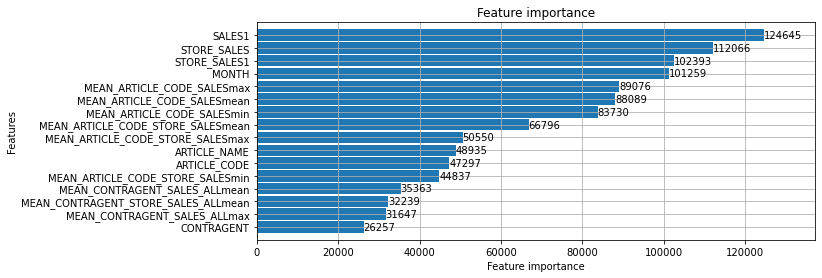

In [24]:
plt.rcParams["figure.figsize"] = (10, 4)
lightgbm.plot_importance(lgbm_model,max_num_features = 16,height=.9)

Вывод: 
- Регрессионная модель показала результаты чуть лучше, чем просто средние показатели продаж за предыдущие месяцы.
- Feature impotance : Показатель продаж за предыдущий месяц, продажи магазина и продажи магазина за предыдущий месяц, месяц по возрастанию (тут это не категоральный признак).

# Задача 2:

In [25]:
clas = pd.read_csv(r'C:\\Users\\Svyatoslav\\Downloads\\data_classification_for_task.csv')

In [26]:
clas.describe()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [27]:
clas.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [28]:
categorical_feature = ['GENDER','FEATURE_1','FEATURE_2','FEATURE_4','FEATURE_5','FEATURE_7','FEATURE_9','FEATURE_10','FEATURE_11']

In [29]:
y = clas['TARGET']
X = clas.drop(['TARGET'],axis = 1)

In [30]:
#Найдем оптимальные гиперпараметры с помощью optuna
import optuna

def objective(trial,X=X,y=y):
   
    cat_parameters = {
        # 'bootstrap_type':'Poisson',
        'eval_metric': 'F1',
        'n_estimators': 5000,
        'random_seed' : 100,
        # 'task_type': 'GPU',
        # 'devices':'0:1',
        'max_depth': trial.suggest_int('max_depth',2,10,1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),
        'max_bin': trial.suggest_int('max_bin', 2, 10,1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2,10,1),
        'subsample': trial.suggest_loguniform('subsample',0.1,0.99),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01,5),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.01,0.99),
    }

    n_splits=10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=101)
    f1 = []
    for trn_idx, val_idx in tqdm(kf.split(X,y)):
        x_train_idx = X.iloc[trn_idx]
        y_train_idx = y.iloc[trn_idx]
        x_valid_idx = X.iloc[val_idx]
        y_valid_idx = y.iloc[val_idx]

        cat_model = CatBoostClassifier(**cat_parameters)
        cat_model.fit(x_train_idx, y_train_idx, eval_set = ((x_valid_idx,y_valid_idx)),verbose = 0, cat_features = categorical_feature,early_stopping_rounds = 200,plot =False) 
        f1.append(f1_score(y_valid_idx, (cat_model.predict_proba(x_valid_idx)[:,1] > 0.5).astype(int)))
    return np.mean(f1)

In [31]:
# 10 циклов для наглядности
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-05-07 10:31:13,173] A new study created in memory with name: no-name-5104badd-9db8-4e20-8a04-d21b91a4240c
10it [00:24,  2.49s/it]
[I 2021-05-07 10:31:38,044] Trial 0 finished with value: 0.8949422364198094 and parameters: {'max_depth': 7, 'learning_rate': 0.0009591006403947615, 'max_bin': 7, 'min_data_in_leaf': 9, 'subsample': 0.10652277052284859, 'l2_leaf_reg': 2.1272978798627467, 'colsample_bylevel': 0.09559557977370217}. Best is trial 0 with value: 0.8949422364198094.
10it [01:06,  6.68s/it]
[I 2021-05-07 10:32:44,896] Trial 1 finished with value: 0.8820870516236541 and parameters: {'max_depth': 7, 'learning_rate': 0.0003525591213797033, 'max_bin': 10, 'min_data_in_leaf': 6, 'subsample': 0.22297086076209469, 'l2_leaf_reg': 0.5010071773189324, 'colsample_bylevel': 0.461472704792578}. Best is trial 0 with value: 0.8949422364198094.
10it [00:17,  1.78s/it]
[I 2021-05-07 10:33:02,703] Trial 2 finished with value: 0.8987818544041645 and parameters: {'max_depth': 3, 'learning_rate

Number of finished trials: 10
Best trial: {'max_depth': 3, 'learning_rate': 1.5258936077540724e-06, 'max_bin': 7, 'min_data_in_leaf': 5, 'subsample': 0.9639036495772872, 'l2_leaf_reg': 4.275172908553342, 'colsample_bylevel': 0.3229493314340853}


In [32]:
#Гиперпараметры
study.best_trial.params

{'max_depth': 3,
 'learning_rate': 1.5258936077540724e-06,
 'max_bin': 7,
 'min_data_in_leaf': 5,
 'subsample': 0.9639036495772872,
 'l2_leaf_reg': 4.275172908553342,
 'colsample_bylevel': 0.3229493314340853}

In [33]:
cat_parameters = study.best_trial.params
cat_parameters['eval_metric'] = 'F1'
cat_parameters['random_seed'] = 100
cat_parameters['n_estimators'] = 5000

In [34]:
# Catboost и Метрика F1
n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=101)
f1 = [] 
for trn_idx, val_idx in tqdm(kf.split(X,y)):
    x_train_idx = X.iloc[trn_idx]
    y_train_idx = y.iloc[trn_idx]
    x_valid_idx = X.iloc[val_idx]
    y_valid_idx = y.iloc[val_idx]

    cat_model = CatBoostClassifier(**cat_parameters)
    cat_model.fit(x_train_idx, y_train_idx, eval_set = ((x_valid_idx,y_valid_idx)),verbose = 0, cat_features = categorical_feature,early_stopping_rounds = 200,plot =False) 
    f1.append(f1_score(y_valid_idx, (cat_model.predict_proba(x_valid_idx)[:,1] > 0.5).astype(int)))
print(f' F1_score: {np.mean(f1)}')

10it [00:16,  1.63s/it]

 F1_score: 0.8987818544041645


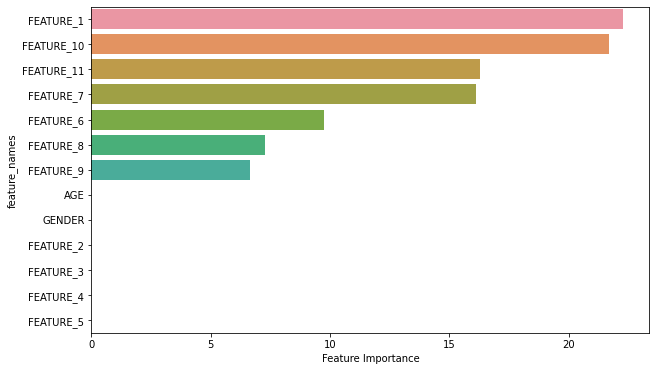

In [35]:
#Feature Importance
def plot_feature_importance(importance,names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.xlabel('Feature Importance')
plot_feature_importance(cat_model.get_feature_importance(),X.columns)